# AOS 573 Final Project
## Ben FitzGerald
### Regional Rainfall Homogeneity Analysis

Rainfall frequency analysis has historically been station record based. These observations are used to calulate the size of a storm that has a 1% chance of occuring each year, which is know a "100-year" storm. This label is misleading because more than one of these storms can occur in a location within a century. Of course, the math behind independent events tell us why it is actually very likely to have more than one of these "100-year" events occur in 100 years. Another cause for more of these events occuring is the changing climate. If rainfall becomes more extreme, then just using historical data to predict events will cause estimates to be wrong. The main cause we will be exploring in this project is error in the estimates. Rainfall estimates are limited spatially and temporaily. Estimates for rainfall are based on records that are shorter than 100 years. In order to decrease error is to increase the record length. One method for doing this is to generate possible storms based on historical storm characteristics. For this project though, we will be exploring stochatic storm transposition (SST). SST is the process selecting storms from the historical record and moving and scaling them to a the location of interest. This allows us to artificially augment the storm record for a location to create better estimates. 

The main goal of this project is to create a work flow for determining if an area is valid for SST. We determine this by performing statistics on the rainfall records of different locations. 

### Part 0: Setup:

In [26]:
import climetlab as cml
import xarray as xr
import scipy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.gridspec as gridspec
import __init__ as lmom1
import distr as lmom2

### Part 1: Retrieval of Data  

Analysis of Record Calibration (AORC) is one of NOAA's gridded records of precipitation. The database can be accessed <a href="https://hydrology.nws.noaa.gov/aorc-historic/" target="_blank">here</a>.
<br>AORC is at 0.033 degree resolution and has hourly measurements. We can download the data pretty easily using CliMetLab. 

In [27]:
URL='https://hydrology.nws.noaa.gov/aorc-historic/AORC_ABRFC_4km/ABRFC_precip_partition/AORC_APCP_4KM_ABRFC_197902.zip'
ABRFCdata = cml.load_source("url",URL, verify=False)
ABRFCds=ABRFCdata.to_xarray()

C:\Users\benfi\anaconda3\envs\AOS573Proj\Lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'hydrology.nws.noaa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


However, this was only on piece of data. Because the data is seperated into River Forecasting Centers, the files must be downloaded seperately. Using xarray, we can merge the files together to get one large dataset. <br> To save a couple minutes, I have prepared the rest of the zip files and merged them into one file. I have plotted the data seperately to help visualize the results of the merge.

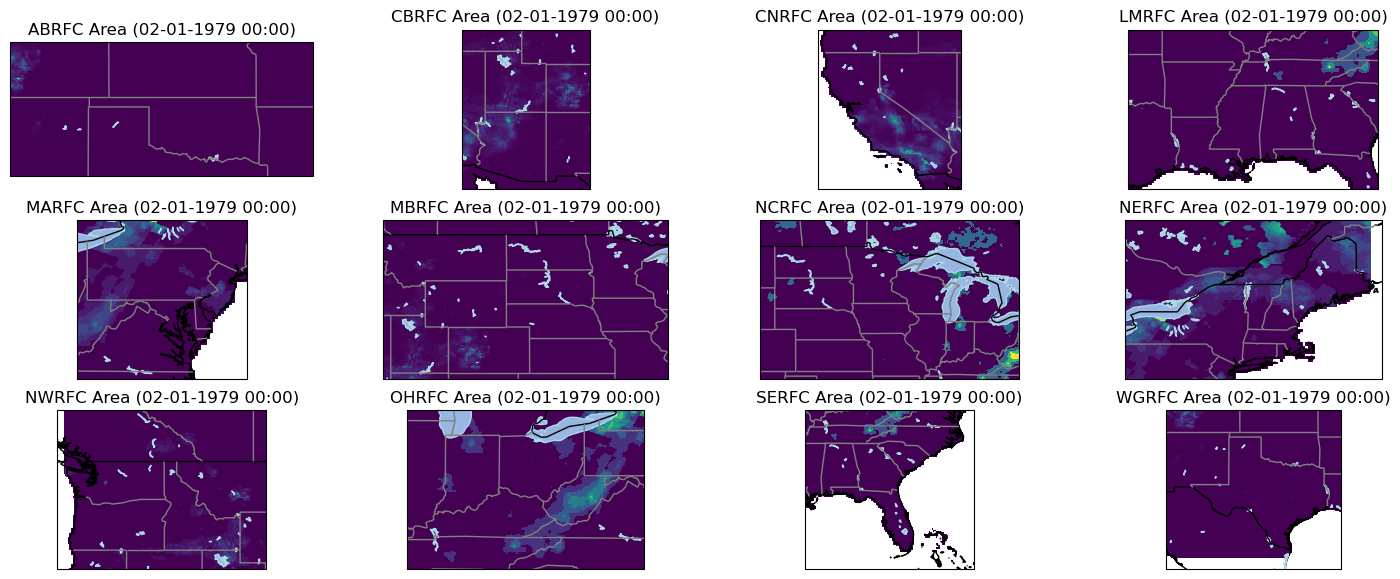

In [28]:
fig=plt.figure(figsize=(18,7))
# Piece of code to add state lines to figure. 
states_provinces = cfeature.NaturalEarthFeature(
       category='cultural',
       name='admin_1_states_provinces_lines',
       scale='50m',
       facecolor='none')

# List of the River Forcasting Centers:
RFCArray=['ABRFC','CBRFC','CNRFC', 'LMRFC', 'MARFC', 'MBRFC', 'NCRFC', 'NERFC', 'NWRFC', 'OHRFC', 'SERFC', 'WGRFC']

count=1
for aa in RFCArray: 
    fileName="Data/AORC_APCP_"+aa+"_1979020100.nc4"
    ds = xr.open_dataset(fileName)
    precip=ds.APCP_surface.isel(time=0)
    ax=fig.add_subplot(3,4,count,projection=ccrs.PlateCarree())
    cs=ax.pcolormesh(ds.longitude,ds.latitude,precip,transform=ccrs.PlateCarree()) 
    #ax.set_extent([-125,-67,25,50],ccrs.PlateCarree())
    ax.coastlines()

    ax.add_feature(cfeature.LAKES, edgecolor='lightblue')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(states_provinces, edgecolor='gray')
    ax.set_title(aa+' Area (02-01-1979 00:00)')
    count=count+1

    # I've commented out the line that actually merges because it takes a while. 
   
    #finalDS=xr.merge([finalDS, ds])


If you want to actually run the merge uncomment the line (it takes 8.5 minutes to do on the Jupyter Hub). The combined data is shown below:

Text(0.5, 1.0, 'AORC Data for 02/01/1979 00:00:00')

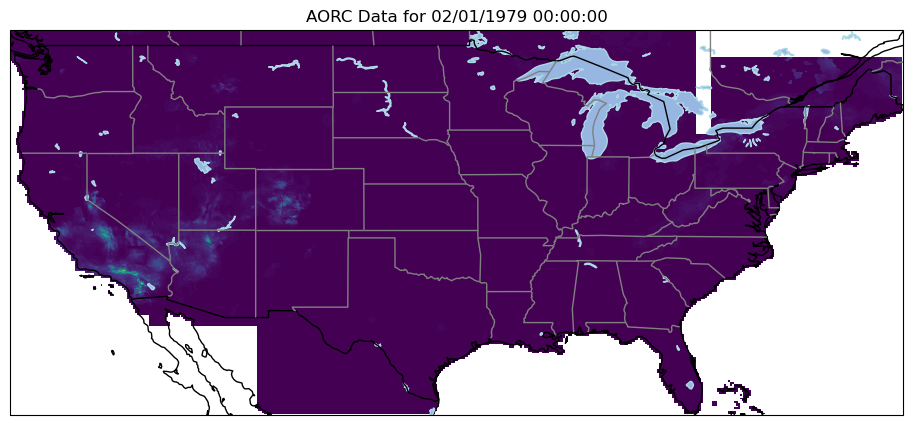

In [29]:
fileName="Data/CombinedData.nc"
finalDS = xr.open_dataset(fileName)

fig=plt.figure(figsize=(18,5))
ax=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
cs=ax.pcolormesh(finalDS.longitude,finalDS.latitude,finalDS.APCP_surface,transform=ccrs.PlateCarree()) 
ax.set_extent([-125,-67,25,50],ccrs.PlateCarree())
ax.coastlines()

ax.add_feature(cfeature.LAKES, edgecolor='lightblue')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(states_provinces, edgecolor='gray')
ax.set_title('AORC Data for 02/01/1979 00:00:00')

In order to create a full dataset of gridded precipitation data, this process would need to be repeated for all 40 years of data. This took days to do and creates an huge amount of data, so I've skipped it in this report.


### Part 2: Homogenous Region Setup

First we will choose what area we want to check for homogeneity. For this project, I am curious about the the Midwest. 

In [30]:
# Here is a list of cities:
Madison=[-89.4008, 43.0722]
Milwaukee=[-87.9065, 43.0389]
Chicago=[-87.6289, 41.8781]
MSP=[-93.2650, 44.9778]
CedarRapids=[-91.6656, 41.9779]
DesMoines=[-93.6250, 41.5868]
GreenBay=[-88.0133,44.5133]
SouthBend=[-86.2520,41.6764]
StLouis=[-90.1994,38.6270]
Detroit=[-83.0458,42.3314]

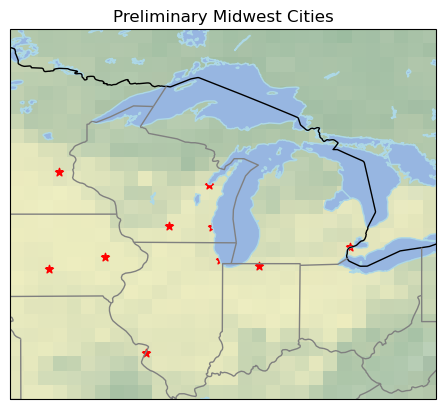

In [31]:
CitiesLat=np.array([Madison[1],MSP[1],DesMoines[1],Milwaukee[1],Chicago[1],CedarRapids[1],GreenBay[1],SouthBend[1],StLouis[1],Detroit[1]])
CitiesLon=np.array([Madison[0],MSP[0],DesMoines[0],Milwaukee[0],Chicago[0],CedarRapids[0],GreenBay[0],SouthBend[0],StLouis[0],Detroit[0]])

fig=plt.figure()
ax1=fig.add_subplot(111,projection=ccrs.PlateCarree())


ax1.stock_img()
ax1.add_feature(cfeature.LAKES, edgecolor='lightblue')
ax1.set_title('Preliminary Midwest Cities')
ax1.coastlines()

ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(states_provinces, edgecolor='gray')
ax1.set_extent([-95,-80,37,50],ccrs.PlateCarree())
ax1.scatter(CitiesLon,CitiesLat,color='r', marker='*')

For my research, I would use a shapefile containing the cities to mask the gridded data. However, this would be an area of thousands of grid cells, which would be sizable and take some time to process. Instead for this project we will use the data from a single grid point for each of these cities which should allow us to speed up the process. 

To calculate the annual maxima for each city, we load the precipitation data for each year. We have to choose a storm duration which is the length of time over which we add hourly rainfalls together and then find the maximum of that set.  

In [32]:
duration=24    # How long storm duration is.  
year=1980
StormCatalog=np.zeros([40,10])

for aa in range(0,40):
    yearstr=str(year)
    YearData=np.load('Data/AOS'+yearstr+'.npy')
    cs=np.cumsum(YearData,axis=0)
    shift=np.roll(cs, shift=duration, axis=0)
    shift[0:duration, :]=0
    stormTotals=cs-shift
    StormCatalog[aa,:]=np.max(stormTotals, axis=0)
    year=year+1

Next we normalize the site records by divinding the records of each site by the average of each site. 

In [33]:
SiteMeans=np.mean(StormCatalog,axis=0)
SStormCatalog=StormCatalog/SiteMeans

Below we plot the histograms of normalized annual maximum storms for each city.

Text(0.5, 1.0, 'South Bend')

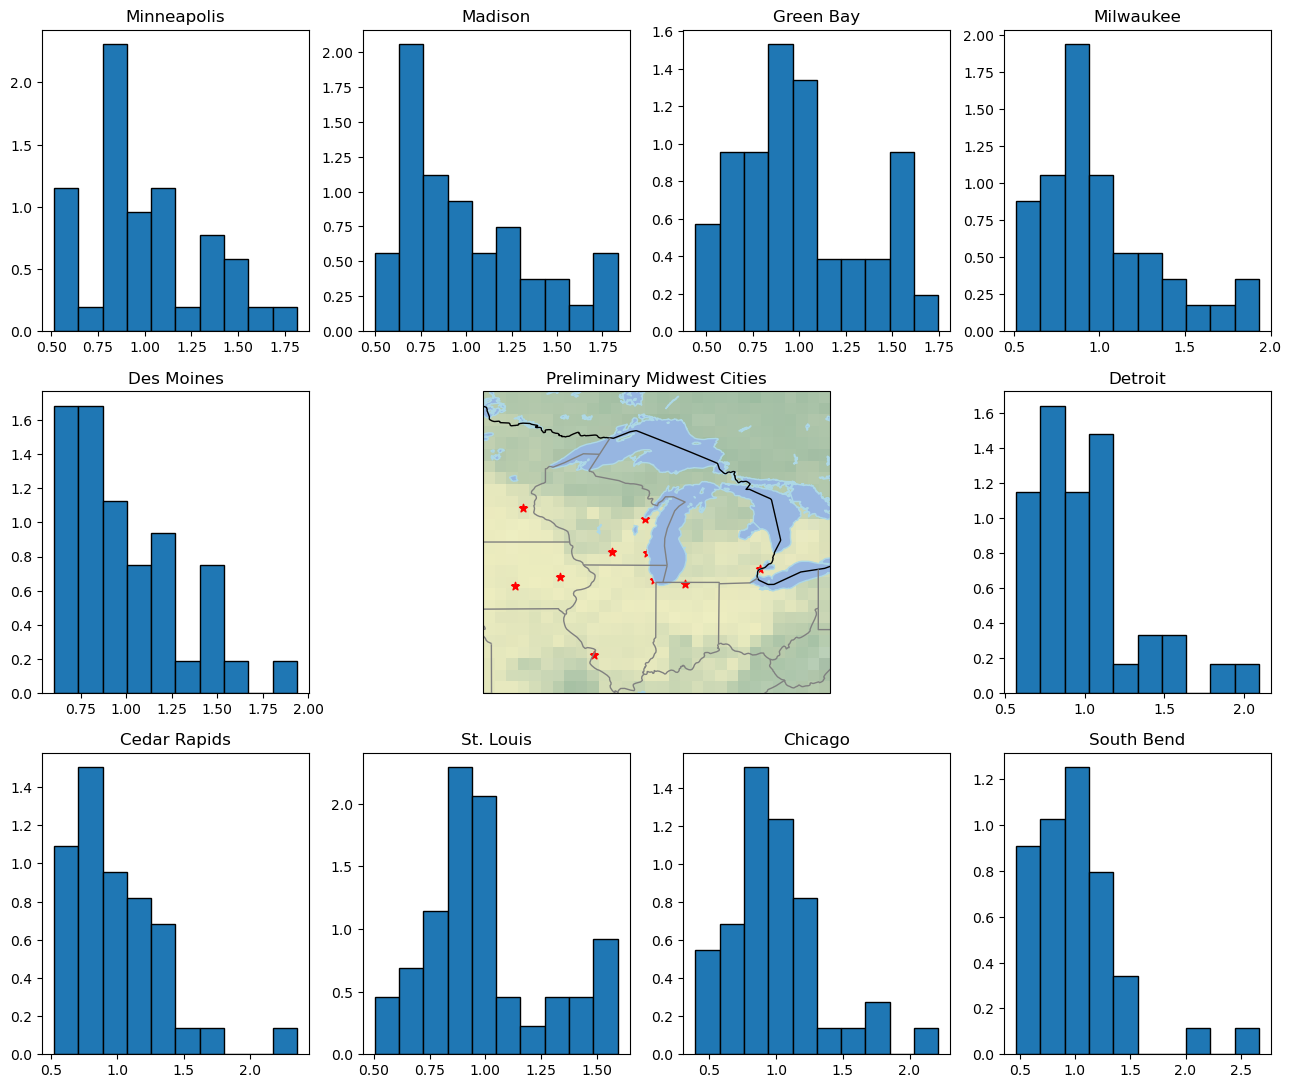

In [34]:
#set up the gridspec
gs=gridspec.GridSpec(nrows=4,ncols=5)

#Set up some axes within the gridspec
#In this case we are adding a suplot at each location, for a total of 16 subplots
fig=plt.figure(figsize=(20,18))
ax0=fig.add_subplot(gs[1:2,1:3],projection=ccrs.PlateCarree()) #upper left, single cell plot
ax1=fig.add_subplot(gs[0,0])
ax2=fig.add_subplot(gs[0,1])
ax3=fig.add_subplot(gs[0,2]) 
ax4=fig.add_subplot(gs[0,3]) 
ax5=fig.add_subplot(gs[1,0]) 
ax6=fig.add_subplot(gs[1,3])
ax7=fig.add_subplot(gs[2,0])
ax8=fig.add_subplot(gs[2,1])
ax9=fig.add_subplot(gs[2,2])
ax10=fig.add_subplot(gs[2,3])

ax0.stock_img()
ax0.add_feature(cfeature.LAKES, edgecolor='lightblue')
ax0.set_title('Preliminary Midwest Cities')
ax0.coastlines()

ax0.add_feature(cfeature.BORDERS)
ax0.add_feature(states_provinces, edgecolor='gray')
ax0.set_extent([-95,-80,37,50],ccrs.PlateCarree())
ax0.scatter(CitiesLon,CitiesLat,color='r', marker='*')

ax1.hist(SStormCatalog[:,3], density=True, edgecolor="black")
ax1.set_title('Minneapolis')

ax2.hist(SStormCatalog[:,0], density=True, edgecolor="black")
ax2.set_title('Madison')

ax3.hist(SStormCatalog[:,6], density=True, edgecolor="black")
ax3.set_title('Green Bay')

ax4.hist(SStormCatalog[:,1], density=True, edgecolor="black")
ax4.set_title('Milwaukee')

ax5.hist(SStormCatalog[:,5], density=True, edgecolor="black")
ax5.set_title('Des Moines')

ax6.hist(SStormCatalog[:,9], density=True, edgecolor="black")
ax6.set_title('Detroit')

ax7.hist(SStormCatalog[:,4], density=True, edgecolor="black")
ax7.set_title('Cedar Rapids')
              
ax8.hist(SStormCatalog[:,8], density=True, edgecolor="black")
ax8.set_title('St. Louis')
                
ax9.hist(SStormCatalog[:,2], density=True, edgecolor="black")
ax9.set_title('Chicago')
              
ax10.hist(SStormCatalog[:,7], density=True, edgecolor="black")
ax10.set_title('South Bend')

### Part 2: Region Analysis

Visually it is hard to tell if the distributions for each site are acceptably similar.  
<br> To do this we will follow a procedure for Regional Frequency Analysis based on L-Moments which was developed by J.R.M. Hosking and J.R. Wallis in <a href="https://search.library.wisc.edu/catalog/999833520702121" target="_blank">Region Frequency Analysis</a>.
L-moments are statistical properties that are similar to normal statistical moments (mean, standard deviation, skewness and kurtosis) that are probability weighted. They are more flexible for describing discribing distributions which help to model distributions of data that have different distributions.

#### Discordancy Measure
The first step will be calculating a discordancy measure for each of the sites. The discordancy measure is how different the l-moments of a site are from the average l-moments of all the sites. This value helps to weed out any outlier dat

In [35]:
def LMI(data):
    Uall=np.zeros(3)
    SgData=data
    SgData=SgData[~np.isnan(SgData)]
    SgData=SgData[np.nonzero(SgData)]    
    SgData=SgData/np.mean(SgData)   # Uncomment to scale data
    As=lmom1.lmom_ratios(SgData,4)
    Uall[0]=As[1]/As[0]
    Uall[1]=As[2]
    Uall[2]=As[3]
    return Uall

def sampCov(Uall):
    N=np.shape(Uall)
    N=N[1]
    SCsum=0
    Um=np.mean(Uall, 1)
    for aa in range(0,N):
        U=np.atleast_2d(Uall[:,aa]-Um).T
        Ut=U.T
        SCsum=SCsum+np.matmul(U,Ut)
    S=((N-1)**(-1))*SCsum
    return S

def mDisc(Uall,S):
    N=np.shape(Uall)
    N=N[1]
    Um=np.mean(Uall, 1)
    Si= np.linalg.inv(S)
    D=np.zeros(N)
    for aa in range(0,N):
        U=np.atleast_2d(Uall[:,aa]-Um).T
        Ut=U.T
        D[aa]=(N/(3*(N-1)))*np.matmul(np.matmul(Ut,Si),U)
    return D

Data=StormCatalog
DataSize=np.shape(Data)
NSITES=DataSize[1] # number of sites in Data
SiteMean=np.nanmean(Data, axis=0)
Data=Data/np.nanmean(Data, axis=0)

# Regional Heterogeneity Functions  

# Create arrays of site record lengths, all sites records, and L-Moment Index 
LEN=np.zeros(NSITES)
DataList=[]
YearList=np.array(range(41))
yearList=[]
UALL=np.zeros((3,NSITES))
for aa in range(0,NSITES):
    LEN[aa]=np.count_nonzero(~np.isnan(Data[:,aa]))
    newSource=Data[~np.isnan(Data[:,aa]),aa]
    DataList=np.append(DataList,newSource) #Uncomment if want all record data in a vector
    yearList=np.append(yearList,YearList)
    UALL[0:3,aa]=LMI(Data[:,aa])


# Create sample covariance matrix
SampleCovariance=sampCov(UALL)

# Calculate measure of discordancy for each station

MoDiscordancy=mDisc(UALL, SampleCovariance)


In [36]:
Dlim=(10-1)/3
print('Maximum limit for the measure of discordancy is',Dlim)

Maximum limit for the measure of discordancy is 3.0


As you can see in the table below, none of the sites are discordant. 

| City | Discordancy |
| --- | --- |
|Madison|1.38044145|
|Milwaukee|0.11880879|
|Chicago|0.76398569|
|Minneapolis|0.90919071|
|Cedar Rapids|0.21117125|
|Des Moines|1.53109087|
|Green Bay| 1.28221712|
|South Bend|1.22106754|
|Saint Louis| 1.78226652|
|Detroit| 0.79976006|

#### Regional Heterogeneity Measure

We say a region is homogenous if the scaled data from all the sites seems likely to come from the same distibution. 
Because none of our cities were eliminated from the set due to discordancy measures, the assumed distribution is a kappa distribution (chosen because it uses four parameters) that is based on the weighted average of sites's l-moments. 
The measurement of the heterogeneity of the region is determined by comparing the actual data to data that was generated using Monte Carlo simulations of the assumed distribution.

In [37]:
#This function creates the regional l-moment index, which is a weighted average of the sites' l-moment index
def RLMI(Uall, lengths):
    Usize=int(np.size(Uall)/np.size(lengths))
    Um=np.zeros(Usize)
    for aa in range(0,Usize):
        Um[aa]=np.average(Uall[aa,:], weights=lengths)
    return Um 

UR= RLMI(UALL,LEN)

In [38]:
# Once we have the regional l-moment index, we can find the parameters for the kappa distribution that fit the overall region distribution best. 
rlmi=np.append(1,UR)
KappaParams=lmom2.kap._lmom_fit(rlmi)
Kappah, Kappak, Kappal, Kappas = KappaParams['h'],KappaParams['k'],KappaParams['loc'],KappaParams['scale']

In [39]:
def wsd(lengths, Uall, Ur):
    N=np.size(lengths)
    botSum=0
    topSum=0
    
    for aa in range(0,N):
        ssn=lengths[aa]
        topSum=topSum+(ssn*((Uall[(0,aa)]-Ur[0])**2))
        botSum=botSum+ssn
    V=(topSum/botSum)**(1/2)
    return V

from numpy.random import default_rng

nRuns=1
nsims=500
# Initialize Arrays 
mVsims=np.zeros(nRuns)
stdVsims=np.zeros(nRuns)
H=np.zeros(nRuns)
B4=np.zeros(nRuns)
std4=np.zeros(nRuns)

simData=np.zeros((int(np.max(LEN)), NSITES,nsims))
simU=np.zeros((3,NSITES))
simUR=np.zeros((3,nsims))

ZGLO=np.zeros(nRuns)
ZGEV=np.zeros(nRuns)
ZP3=np.zeros(nRuns)
ZGPA=np.zeros(nRuns)
ZLNO=np.zeros(nRuns)

# Initialize Arrays 
mVsims=np.zeros(nRuns)
stdVsims=np.zeros(nRuns)
H=np.zeros(nRuns)

iData=np.zeros((int(np.max(LEN)), NSITES,nsims+1))
simList=[]
simData=np.zeros((int(np.max(LEN)), NSITES,nsims))
iU=np.zeros((3,NSITES,nsims+1))
iUR=np.zeros((3,nsims+1))
iV=np.zeros(nsims+1)

for nn in range(0,nRuns):
    B4sum=np.zeros(nsims)
    SDsum=np.zeros(nsims)
    
    # Use nsim simulations to calculate heterogeneity measure and goodness-of-fit measure for each distribution
    for aa in range(0,nsims+1):     
        if aa==0:  # For first aa set data to the record data
            iData[:,:,aa]=Data
        else:      # The other data is simulated and added to array 
            for bb in range(0,NSITES):
                SourceCount=int(LEN[bb])
                rng = default_rng()
                ndVar=rng.random(SourceCount)
                SourceNew = lmom2.kap.ppf(ndVar,k=KappaParams['k'],h=KappaParams['h'],loc=KappaParams['loc'], scale=KappaParams['scale'])
                simData[0:SourceCount,bb,aa-1]=SourceNew
            iData[:,:,aa]=simData[:,:,aa-1]
        
        # Iterate through each site to calculate L-moment index for each one.
        for cc in range(0,NSITES):
            iU[:,cc,aa]=LMI(iData[:,cc,aa])
        
        # Once L-moments for each site are calculated, calculate regional L-Moment index and weighted standard deviation for record and all simulations.   
        iUR[0:3,aa]=RLMI(iU[:,:,aa],LEN)
        iV[aa]=wsd(LEN, iU[:,:,aa], iUR[:,aa])
        
        if aa>0:
            B4sum[aa-1]=iUR[2,aa]-UR[2]
            SDsum[aa-1]=(B4sum[aa-1])**2
    VData=iV[0]   # Weighted standard deviation of the record data
    Vsims=iV[1:nsims+1] # Weighted standard deviations for each simulation

    mVsims[nn]=np.mean(Vsims) # Mean of weighted standard deviations of simulations 
    stdVsims[nn]=np.std(Vsims, ddof=1) # Standard deviation of the weighted standard deviations of the simulations
    
    H[nn]=(VData-mVsims[nn])/stdVsims[nn] # Calculation of heterogeneity 
    
print('Initial Heterogeneity measure is ', np.mean(H))

Initial Heterogeneity measure is  -0.8808089524257932


This value of heterogeneity indicates that our cities form a homogenous region. However, the negative value indicates some cross-correlation.
We can use a procedure to remove some of this correlation, which will give a more accurate heterogeneity measure. 

In [40]:
Corray=np.zeros([NSITES,NSITES])
for aa in range(0,NSITES):
    for bb in range(0,NSITES):
        Pres=scipy.stats.pearsonr(StormCatalog[:,aa],StormCatalog[:,bb])
        Corray[aa,bb]=Pres[0]
        CTotal=(np.sum(Corray)-NSITES)/2
        Rho=CTotal/(((NSITES**2)-NSITES)/2)

Hadj=H+(0.122*(Rho**2)*(NSITES-1))
print('Adjusted H value is', Hadj[0])

Adjusted H value is -0.8074127305951998


The adjustment didn't do much but this final H indicates that our cities form an acceptably homogenous region to perform SST on. 

My advisor, Dan Wright, has a code RainyDay that performs this type of analysis. However, it is a bit complicated to incorporate. Instead, I will use the new regional distibutions to create new rainfall estimates instead of simulating them. 
<br> The first step is to find the parameters for each of our distibutions from the Regional L-moment index as we did with kappa distibution above. Then we find the l-moment from those distributions (which will be slightly different than the ones calculated)

In [43]:
# Calculate other distribution parameters based on Regional L-moment Index
GLOParams=lmom2.glo._lmom_fit(rlmi[0:3])
GLOk, GLOl, GLOs = GLOParams['k'],GLOParams['loc'],GLOParams['scale']
rlmiGLO=lmom2.glo.lmom_ratios(nmom=4, **GLOParams)
GLOT4=rlmiGLO[3]

GEVParams=lmom2.gev._lmom_fit(rlmi[0:3])
GEVc, GEVl, GEVs = GEVParams['c'],GEVParams['loc'],GEVParams['scale']
rlmiGEV=lmom2.gev.lmom_ratios(nmom=4, **GEVParams)
GEVT4=rlmiGEV[3]

GPAParams=lmom2.gpa._lmom_fit(rlmi[0:3])
GPAc, GPAl, GPAs = GPAParams['c'],GPAParams['loc'],GPAParams['scale']
rlmiGPA=lmom2.gpa.lmom_ratios(nmom=4, **GPAParams)
GPAT4=rlmiGPA[3]

LNOParams=lmom2.gno._lmom_fit(rlmi[0:3])
LNOk, LNOl, LNOs = LNOParams['k'],LNOParams['loc'],LNOParams['scale']
rlmiLNO=lmom2.gno.lmom_ratios(nmom=4, **LNOParams)
LNOT4=rlmiLNO[3]

P3Params=lmom2.pe3._lmom_fit(rlmi[0:3])
P3sk, P3l, P3s=  P3Params['skew'],P3Params['loc'],P3Params['scale']
rlmiP3=lmom2.pe3.lmom_ratios(nmom=4, **P3Params)
P3T4=rlmiP3[3]

To calculate the goodness of fits for the distributions, we find the difference between the L-Kurtosis of the data fitted to a distribution and the L-Kurtosis of the region. We calculate the bias and standard deviation of the regional L-kurtosis (which are needed to calculate goodness-of-fit for each distribution) using the Monte Carlo simulation done earlier. 

In [44]:
B4=(nsims**-1)*np.sum(B4sum)
std4=(((nsims-1)**(-1))*((np.sum(SDsum))-(nsims*(B4**2))))**(1/2)

ZGLO=(GLOT4-UR[2]+B4)/std4
ZGEV=(GEVT4-UR[2]+B4)/std4
ZP3=(P3T4-UR[2]+B4)/std4
ZGPA=(GPAT4-UR[2]+B4)/std4
ZLNO=(LNOT4-UR[2]+B4)/std4 

The goodness-of-fit results are shown in the table below (your results may be slightly different depending on the simulation). Acceptable distributions have absolute values less than 1.64. However, we will look at the best fit which is the lognormal distribution.

| Distribution | Goodness-of-Fit |
| --- | --- |
|Generalized Logistic|2.365|
|Generalized Extreme Value|0.625|
|Pearson Type III|-0.823|
|Generalized Pareto|-3.47|
|Lognormal|0.14|

We can now use the lognormal distribution and the parameters we found earlier to create a regional rainfall distribution. We scale each distribution by the mean at each site to get a new distribution at each site. 

In [45]:
ReturnYears=np.logspace(0,3,num=50)
RPercs=1-(1/ReturnYears)

RPLNO=scipy.stats.lognorm.ppf(RPercs,LNOk, loc=LNOl, scale=LNOs)
RPLNO
print('K=',LNOk)

K= -0.4339503355759836


The lognormal distribution doesn't work using scipy because scipy only creates distributions for K>0. So instead, we will use the generalized extreme value distribution and the pearson type III distribution which have acceptable goodness-of-fit values. 

(0.0, 4.0)

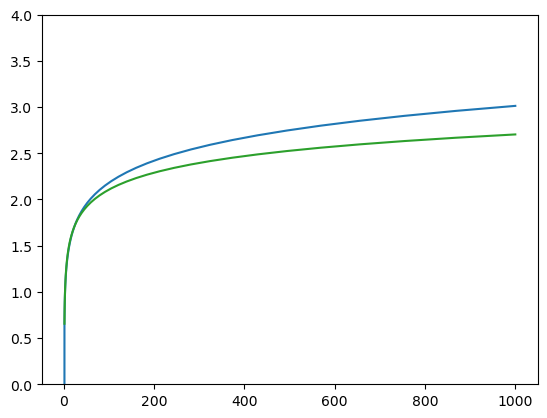

In [46]:
RPGEV=scipy.stats.genextreme.ppf(RPercs,GEVc, loc=GEVl, scale=GEVs)
RPPE3=scipy.stats.pearson3.ppf(RPercs,P3sk, loc=P3l, scale=P3s)

plt.plot(ReturnYears,RPGEV)
plt.plot(ReturnYears,RPLNO)
plt.plot(ReturnYears,RPPE3)
plt.ylim([0,4])

We can scale this resulting annual return estimate to get an estimate for each city.  

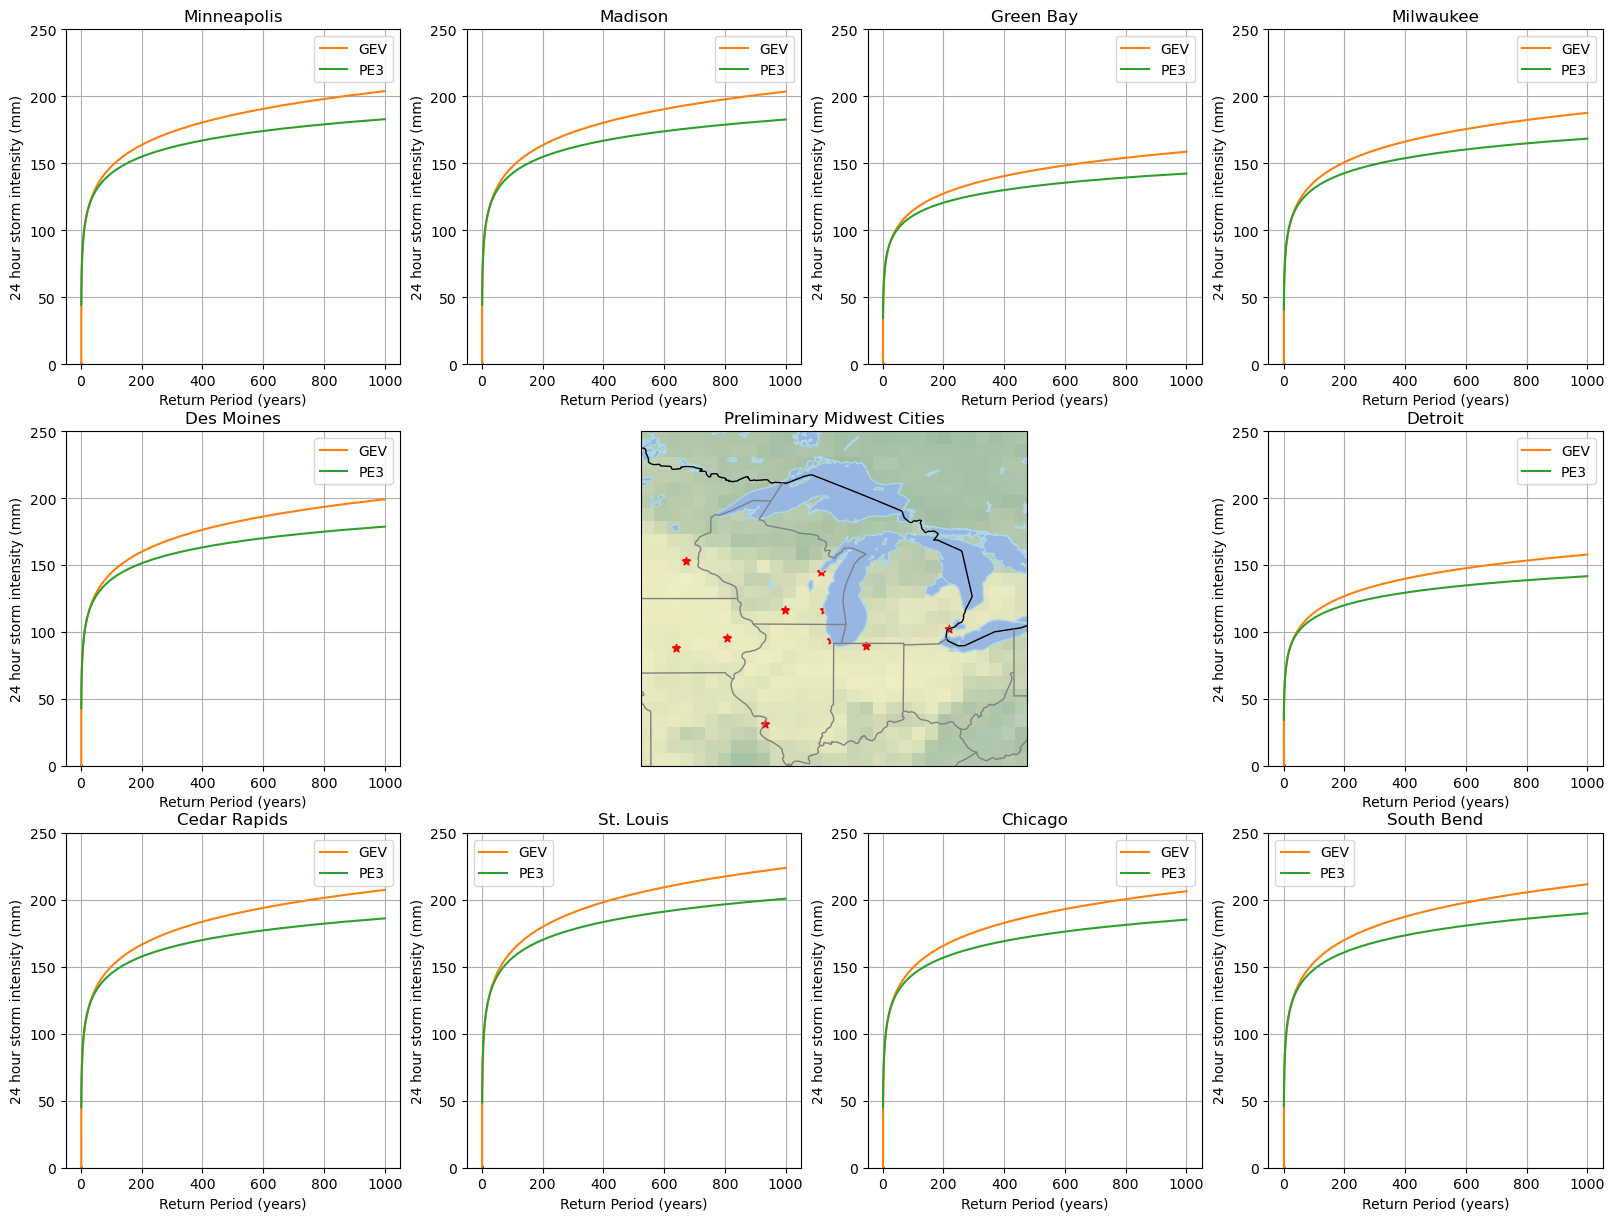

In [47]:
#set up the gridspec
gs=gridspec.GridSpec(nrows=4,ncols=5)

#Set up some axes within the gridspec
#In this case we are adding a suplot at each location, for a total of 16 subplots
fig=plt.figure(figsize=(25,20))
ax0=fig.add_subplot(gs[1:2,1:3],projection=ccrs.PlateCarree()) #upper left, single cell plot
ax1=fig.add_subplot(gs[0,0])
ax2=fig.add_subplot(gs[0,1])
ax3=fig.add_subplot(gs[0,2]) 
ax4=fig.add_subplot(gs[0,3]) 
ax5=fig.add_subplot(gs[1,0]) 
ax6=fig.add_subplot(gs[1,3])
ax7=fig.add_subplot(gs[2,0])
ax8=fig.add_subplot(gs[2,1])
ax9=fig.add_subplot(gs[2,2])
ax10=fig.add_subplot(gs[2,3])

ax0.stock_img()
ax0.add_feature(cfeature.LAKES, edgecolor='lightblue')
ax0.set_title('Preliminary Midwest Cities')
ax0.coastlines()

ax0.add_feature(cfeature.BORDERS)
ax0.add_feature(states_provinces, edgecolor='gray')
ax0.set_extent([-95,-80,37,50],ccrs.PlateCarree())
ax0.scatter(CitiesLon,CitiesLat,color='r', marker='*')

ax1.hist(SStormCatalog[:,3], density=True, edgecolor="black")
ax1.plot(ReturnYears,RPGEV*SiteMean[3])
ax1.plot(ReturnYears,RPPE3*SiteMean[3])
ax1.set_ylim([0,250])
ax1.set_title('Minneapolis')
ax1.grid()
ax1.set_ylabel('24 hour storm intensity (mm)')
ax1.set_xlabel('Return Period (years)')
ax1.legend(['GEV','PE3'])

ax2.hist(SStormCatalog[:,0], density=True, edgecolor="black")
ax2.set_title('Madison')
ax2.plot(ReturnYears,RPGEV*SiteMean[0])
ax2.plot(ReturnYears,RPPE3*SiteMean[0])
ax2.set_ylim([0,250])
ax2.grid()
ax2.set_ylabel('24 hour storm intensity (mm)')
ax2.set_xlabel('Return Period (years)')
ax2.legend(['GEV','PE3'])

ax3.hist(SStormCatalog[:,6], density=True, edgecolor="black")
ax3.set_title('Green Bay')
ax3.plot(ReturnYears,RPGEV*SiteMean[6])
ax3.plot(ReturnYears,RPPE3*SiteMean[6])
ax3.set_ylim([0,250])
ax3.grid()
ax3.set_ylabel('24 hour storm intensity (mm)')
ax3.set_xlabel('Return Period (years)')
ax3.legend(['GEV','PE3'])

ax4.hist(SStormCatalog[:,1], density=True, edgecolor="black")
ax4.set_title('Milwaukee')
ax4.plot(ReturnYears,RPGEV*SiteMean[1])
ax4.plot(ReturnYears,RPPE3*SiteMean[1])
ax4.set_ylim([0,250])
ax4.grid()
ax4.set_ylabel('24 hour storm intensity (mm)')
ax4.set_xlabel('Return Period (years)')
ax4.legend(['GEV','PE3'])

ax5.hist(SStormCatalog[:,5], density=True, edgecolor="black")
ax5.set_title('Des Moines')
ax5.plot(ReturnYears,RPGEV*SiteMean[5])
ax5.plot(ReturnYears,RPPE3*SiteMean[5])
ax5.set_ylim([0,250])
ax5.grid()
ax5.set_ylabel('24 hour storm intensity (mm)')
ax5.set_xlabel('Return Period (years)')
ax5.legend(['GEV','PE3'])

ax6.hist(SStormCatalog[:,9], density=True, edgecolor="black")
ax6.set_title('Detroit')
ax6.plot(ReturnYears,RPGEV*SiteMean[9])
ax6.plot(ReturnYears,RPPE3*SiteMean[9])
ax6.set_ylim([0,250])
ax6.grid()
ax6.set_ylabel('24 hour storm intensity (mm)')
ax6.set_xlabel('Return Period (years)')
ax6.legend(['GEV','PE3'])

ax7.hist(SStormCatalog[:,4], density=True, edgecolor="black")
ax7.set_title('Cedar Rapids')
ax7.plot(ReturnYears,RPGEV*SiteMean[4])
ax7.plot(ReturnYears,RPPE3*SiteMean[4])
ax7.set_ylim([0,250])
ax7.grid()
ax7.set_ylabel('24 hour storm intensity (mm)')
ax7.set_xlabel('Return Period (years)')
ax7.legend(['GEV','PE3'])
           
ax8.hist(SStormCatalog[:,8], density=True, edgecolor="black")
ax8.set_title('St. Louis')
ax8.plot(ReturnYears,RPGEV*SiteMean[8])
ax8.plot(ReturnYears,RPPE3*SiteMean[8])
ax8.set_ylim([0,250])
ax8.grid()
ax8.set_ylabel('24 hour storm intensity (mm)')
ax8.set_xlabel('Return Period (years)')
ax8.legend(['GEV','PE3'])

ax9.hist(SStormCatalog[:,2], density=True, edgecolor="black")
ax9.set_title('Chicago')
ax9.plot(ReturnYears,RPGEV*SiteMean[2])
ax9.plot(ReturnYears,RPPE3*SiteMean[2])
ax9.set_ylim([0,250])
ax9.grid()
ax9.set_ylabel('24 hour storm intensity (mm)')
ax9.set_xlabel('Return Period (years)')
ax9.legend(['GEV','PE3'])

ax10.hist(SStormCatalog[:,7], density=True, edgecolor="black")
ax10.set_title('South Bend')
ax10.plot(ReturnYears,RPGEV*SiteMean[7])
ax10.plot(ReturnYears,RPPE3*SiteMean[7])
ax10.set_ylim([0,250])
ax10.grid()
ax10.set_ylabel('24 hour storm intensity (mm)')
ax10.set_xlabel('Return Period (years)')
ax10.legend(['GEV','PE3'])


This is a cool result, but it doesn't tell us how it compares to other estimates that are used. There are a couple different ways we could mess with the data. The option I chose was to use <a href="https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_map_cont.html" target="_blank">NOAA's ATLAS 14</a> values for each city to compare distributions. 

In [50]:
Rps=[1,2,5,10,25,50,100,200,500,1000]
MadisonRf=[63,72,88,103,126,146,167,191,224,252]
MilwaukeeRf=[59,67,81,95,116,134,154,176,208,234]
ChicagoRf=[62,75,96,113,138,159,183,208,247,279]
MSPRf=[63,72,91,109,137,162,190,221,266,303]
CedarRapidsRf=[66,77,97,114,141,164,188,214,251,281]
DesMoinesRf=[67,77,95,111,135,156,178,202,236,264]
GreenBayRf=[52,60,74,87,106,122,139,157,183,204]
SouthBendRf=[59,71,89,104,125,141,159,178,205,227]
StLouisRf=[71,82,102,120,148,171,197,225,264,296]
DetroitRf=[52,59,72,84,101,115,130,146,169,187]

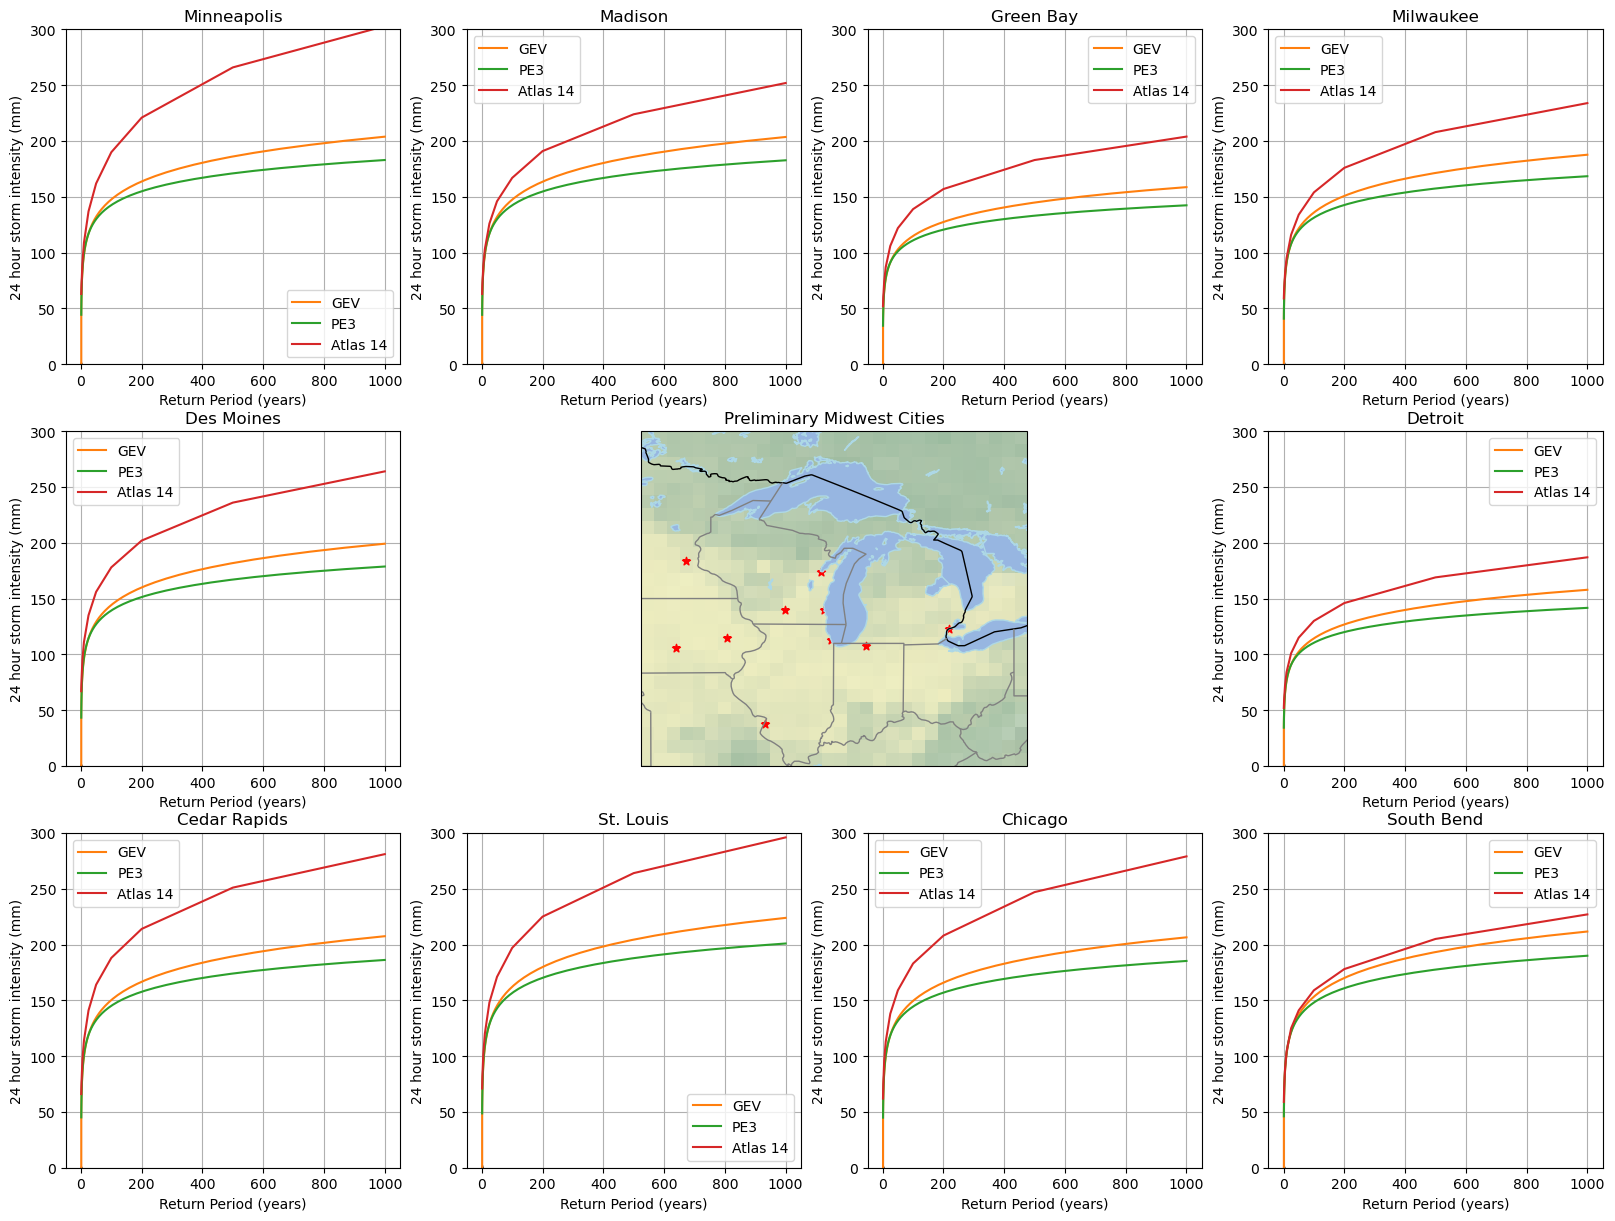

In [51]:
#set up the gridspec
gs=gridspec.GridSpec(nrows=4,ncols=5)

#Set up some axes within the gridspec
#In this case we are adding a suplot at each location, for a total of 16 subplots
fig=plt.figure(figsize=(25,20))
ax0=fig.add_subplot(gs[1:2,1:3],projection=ccrs.PlateCarree()) #upper left, single cell plot
ax1=fig.add_subplot(gs[0,0])
ax2=fig.add_subplot(gs[0,1])
ax3=fig.add_subplot(gs[0,2]) 
ax4=fig.add_subplot(gs[0,3]) 
ax5=fig.add_subplot(gs[1,0]) 
ax6=fig.add_subplot(gs[1,3])
ax7=fig.add_subplot(gs[2,0])
ax8=fig.add_subplot(gs[2,1])
ax9=fig.add_subplot(gs[2,2])
ax10=fig.add_subplot(gs[2,3])

ax0.stock_img()
ax0.add_feature(cfeature.LAKES, edgecolor='lightblue')
ax0.set_title('Preliminary Midwest Cities')
ax0.coastlines()
ax0.add_feature(cfeature.BORDERS)
ax0.add_feature(states_provinces, edgecolor='gray')
ax0.set_extent([-95,-80,37,50],ccrs.PlateCarree())
ax0.scatter(CitiesLon,CitiesLat,color='r', marker='*')

ax1.hist(SStormCatalog[:,3], density=True, edgecolor="black")
ax1.plot(ReturnYears,RPGEV*SiteMean[3])
ax1.plot(ReturnYears,RPPE3*SiteMean[3])
ax1.plot(Rps,MSPRf)
ax1.set_ylim([0,300])
ax1.set_title('Minneapolis')
ax1.grid()
ax1.set_ylabel('24 hour storm intensity (mm)')
ax1.set_xlabel('Return Period (years)')
ax1.legend(['GEV','PE3', 'Atlas 14'])

ax2.hist(SStormCatalog[:,0], density=True, edgecolor="black")
ax2.set_title('Madison')
ax2.plot(ReturnYears,RPGEV*SiteMean[0])
ax2.plot(ReturnYears,RPPE3*SiteMean[0])
ax2.plot(Rps,MadisonRf)
ax2.set_ylim([0,300])
ax2.grid()
ax2.set_ylabel('24 hour storm intensity (mm)')
ax2.set_xlabel('Return Period (years)')
ax2.legend(['GEV','PE3', 'Atlas 14'])

ax3.hist(SStormCatalog[:,6], density=True, edgecolor="black")
ax3.set_title('Green Bay')
ax3.plot(ReturnYears,RPGEV*SiteMean[6])
ax3.plot(ReturnYears,RPPE3*SiteMean[6])
ax3.plot(Rps,GreenBayRf)
ax3.set_ylim([0,300])
ax3.grid()
ax3.set_ylabel('24 hour storm intensity (mm)')
ax3.set_xlabel('Return Period (years)')
ax3.legend(['GEV','PE3', 'Atlas 14'])

ax4.hist(SStormCatalog[:,1], density=True, edgecolor="black")
ax4.set_title('Milwaukee')
ax4.plot(ReturnYears,RPGEV*SiteMean[1])
ax4.plot(ReturnYears,RPPE3*SiteMean[1])
ax4.plot(Rps,MilwaukeeRf)
ax4.set_ylim([0,300])
ax4.grid()
ax4.set_ylabel('24 hour storm intensity (mm)')
ax4.set_xlabel('Return Period (years)')
ax4.legend(['GEV','PE3', 'Atlas 14'])

ax5.hist(SStormCatalog[:,5], density=True, edgecolor="black")
ax5.set_title('Des Moines')
ax5.plot(ReturnYears,RPGEV*SiteMean[5])
ax5.plot(ReturnYears,RPPE3*SiteMean[5])
ax5.plot(Rps,DesMoinesRf)
ax5.set_ylim([0,300])
ax5.grid()
ax5.set_ylabel('24 hour storm intensity (mm)')
ax5.set_xlabel('Return Period (years)')
ax5.legend(['GEV','PE3', 'Atlas 14'])

ax6.hist(SStormCatalog[:,9], density=True, edgecolor="black")
ax6.set_title('Detroit')
ax6.plot(ReturnYears,RPGEV*SiteMean[9])
ax6.plot(ReturnYears,RPPE3*SiteMean[9])
ax6.plot(Rps,DetroitRf)
ax6.set_ylim([0,300])
ax6.grid()
ax6.set_ylabel('24 hour storm intensity (mm)')
ax6.set_xlabel('Return Period (years)')
ax6.legend(['GEV','PE3', 'Atlas 14'])

ax7.hist(SStormCatalog[:,4], density=True, edgecolor="black")
ax7.set_title('Cedar Rapids')
ax7.plot(ReturnYears,RPGEV*SiteMean[4])
ax7.plot(ReturnYears,RPPE3*SiteMean[4])
ax7.plot(Rps,CedarRapidsRf)
ax7.set_ylim([0,300])
ax7.grid()
ax7.set_ylabel('24 hour storm intensity (mm)')
ax7.set_xlabel('Return Period (years)')
ax7.legend(['GEV','PE3', 'Atlas 14'])
           
ax8.hist(SStormCatalog[:,8], density=True, edgecolor="black")
ax8.set_title('St. Louis')
ax8.plot(ReturnYears,RPGEV*SiteMean[8])
ax8.plot(ReturnYears,RPPE3*SiteMean[8])
ax8.plot(Rps,StLouisRf)
ax8.set_ylim([0,300])
ax8.grid()
ax8.set_ylabel('24 hour storm intensity (mm)')
ax8.set_xlabel('Return Period (years)')
ax8.legend(['GEV','PE3', 'Atlas 14'])

ax9.hist(SStormCatalog[:,2], density=True, edgecolor="black")
ax9.set_title('Chicago')
ax9.plot(ReturnYears,RPGEV*SiteMean[2])
ax9.plot(ReturnYears,RPPE3*SiteMean[2])
ax9.plot(Rps,ChicagoRf)
ax9.set_ylim([0,300])
ax9.grid()
ax9.set_ylabel('24 hour storm intensity (mm)')
ax9.set_xlabel('Return Period (years)')
ax9.legend(['GEV','PE3', 'Atlas 14'])

ax10.hist(SStormCatalog[:,7], density=True, edgecolor="black")
ax10.set_title('South Bend')
ax10.plot(ReturnYears,RPGEV*SiteMean[7])
ax10.plot(ReturnYears,RPPE3*SiteMean[7])
ax10.plot(Rps,SouthBendRf)
ax10.set_ylim([0,300])
ax10.grid()
ax10.set_ylabel('24 hour storm intensity (mm)')
ax10.set_xlabel('Return Period (years)')
ax10.legend(['GEV','PE3', 'Atlas 14'])


Unexpectedly, the Atlas-14 values actually are larger than the new values. There are couple of explanations that could be the reason for this. One could be the difference in rainfall measurements. If the AORC data has consistently smaller values than the Atlas-14 data this explains why the estimates are off. Another explanation could be that the Atlas-14 data has large error bounds. A further investigation into how the new estimates fit in the error could show that these are just values with less error. 